# Summarization using LLMs

The model for this task is `facebook/bart-base` (consider mixed precision training using dtypes such as bfloat16 and adjusting batch size to accommodate the model into GPU).

**Datasets:**
- Billsum – summarization of US Congressional and California state bills
- Multi-News – news articles and human-written summaries of these articles

## Step 1: Dataset preparation and preprocessing

1. Select and load one dataset from the list above. You can download these datasets using the `datasets` package.

In [1]:
#!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

In [7]:
import os
import matplotlib.pyplot as plt
from transformers import BartTokenizer
from transformers import BartForConditionalGeneration, BartTokenizer
import torch
from torch.utils.data import DataLoader
from transformers import Trainer
from datasets import load_dataset
from transformers import default_data_collator
import numpy as np
import sacrebleu
import bert_score
import rouge_score
from rouge_score import rouge_scorer
from transformers import BartForConditionalGeneration, TrainingArguments
import matplotlib.pyplot as plt
from evaluate import load as load_metric
from bert_score import score as bert_score

In [8]:
from datasets import load_dataset

dataset = load_dataset("billsum")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.27k [00:01<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/91.8M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.8M [00:00<?, ?B/s]

ca_test-00000-of-00001.parquet:   0%|          | 0.00/6.12M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18949 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3269 [00:00<?, ? examples/s]

Generating ca_test split:   0%|          | 0/1237 [00:00<?, ? examples/s]

2. Analyze the dataset and provide the main statistics (e.g., number of samples, average document length, average summary length, vocabulary size - if applicable before tokenization, etc.).

In [9]:
print(dataset)
print(dataset['train'][0])

train_size = len(dataset['train'])
test_size = len(dataset['test'])

avg_input_length = sum(len(ex['text'].split()) for ex in dataset['train']) / train_size
avg_summary_length = sum(len(ex['summary'].split()) for ex in dataset['train']) / train_size

print(f"Train size: {train_size}")
print(f"Test size: {test_size}")
print(f"Avg input length (words): {avg_input_length:.2f}")
print(f"Avg summary length (words): {avg_summary_length:.2f}")


DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 18949
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 3269
    })
    ca_test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 1237
    })
})
{'text': "SECTION 1. LIABILITY OF BUSINESS ENTITIES PROVIDING USE OF FACILITIES \n              TO NONPROFIT ORGANIZATIONS.\n\n    (a) Definitions.--In this section:\n            (1) Business entity.--The term ``business entity'' means a \n        firm, corporation, association, partnership, consortium, joint \n        venture, or other form of enterprise.\n            (2) Facility.--The term ``facility'' means any real \n        property, including any building, improvement, or appurtenance.\n            (3) Gross negligence.--The term ``gross negligence'' means \n        voluntary and conscious conduct by a person with knowledge (at \n        the time of the conduct) that t

3. Preprocessing:

   - Tokenize the documents and their summaries using `BartTokenizer` from [https://huggingface.co/facebook/bart-base](https://huggingface.co/facebook/bart-base). You can experiment with other tokenizers.

In [10]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

max_input_length = 1024
max_target_length = 256

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

   - Set appropriate maximum input lengths (e.g., 1024 tokens) and target lengths (e.g., 256 tokens).

In [11]:
def preprocess(example):
    model_inputs = tokenizer(
        example["text"],
        max_length=max_input_length,
        truncation=True,
        padding="max_length"
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            example["summary"],
            max_length=max_target_length,
            truncation=True,
            padding="max_length"
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

   - [Optional] Additional pre-processing steps.

In [ ]:
### ADD YOUR CODE HERE ###

4. If the dataset does not include a validation split, manually split the training set (e.g., 90% training, 10% validation).

In [12]:
dataset['train'] = dataset['train'].shuffle(seed=42)
split_dataset = dataset['train'].train_test_split(test_size=0.1)

tokenized_train = split_dataset['train'].map(preprocess, batched=True)
tokenized_val = split_dataset['test'].map(preprocess, batched=True)
tokenized_test = dataset['test'].map(preprocess, batched=True)

Map:   0%|          | 0/17054 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1895 [00:00<?, ? examples/s]

Map:   0%|          | 0/3269 [00:00<?, ? examples/s]

5. Save the tokenized dataset locally to avoid reprocessing.

In [13]:
tokenized_train.save_to_disk("./billsum_tokenized/train")
tokenized_val.save_to_disk("./billsum_tokenized/val")
tokenized_test.save_to_disk("./billsum_tokenized/test")


Saving the dataset (0/1 shards):   0%|          | 0/17054 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1895 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3269 [00:00<?, ? examples/s]

6. Briefly describe your preprocessing methodology.

The `BartTokenizer` from Hugging Face's `facebook/bart-base` model, which works well for summarization tasks, was utilized for preprocessing. To ensure uniform input dimensions, truncation and padding were applied when tokenizing documents and their accompanying summaries. The goal summary length was restricted to 256 characters in order to maintain concise outputs, and the maximum input length was set at 1024 tokens in order to handle longer documents. The training set was manually split into 90% training and 10% validation because the dataset lacked a validation split. To increase efficiency during training and evaluation and avoid repeated preprocessing, the tokenized dataset was kept locally.

## Step 2: Model Fine-Tuning

1. Use the pre-trained model `facebook/bart-base` from Hugging Face.

In [14]:
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

2. Training:

   - Fine-tune the model on the tokenized training set.

In [15]:
min_t_samples = 1000
min_v_samples = 100

tokenized_train = tokenized_train.select(range(min_t_samples)) if len(tokenized_train) > min_t_samples else tokenized_train
tokenized_val = tokenized_val.select(range(min_v_samples)) if len(tokenized_val) > min_v_samples else tokenized_val
tokenized_test = tokenized_test.select(range(min_v_samples)) if len(tokenized_test) > min_v_samples else tokenized_test

   - Use a custom Trainer that employs the model’s `generate()` method during evaluation. Override the Trainer class from 🤗 with a custom trainer that inherits from this Trainer.

In [16]:

class CustomTrainerV2(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.losses = []
        self.metrics = {"rouge": [], "bleu": [], "bert": []}

    def train_and_evaluate(self, logs: dict, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval", start_time=None):

        eval_results = self._evaluate(eval_dataset, ignore_keys, metric_key_prefix)
        self._update_metrics(eval_results)

        return eval_results

    def log(self, logs, *args, **kwargs):
      super().log(logs, *args, **kwargs)
      if "loss" in logs:
          self.losses.append(logs["loss"])


    def _evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        if eval_dataset is None:
            eval_dataset = self.eval_dataset

        results = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)
        predictions = self._generate_predictions(eval_dataset)
        references = self._load_references(len(predictions))
        evaluation_metrics = self._calculate_metrics(predictions, references)

        return {**results, **evaluation_metrics}

    def _generate_predictions(self, eval_dataset):
        self.model.eval()
        eval_loader = DataLoader(eval_dataset, batch_size=4, collate_fn=default_data_collator)
        predictions = []

        for batch in eval_loader:
            input_ids = batch["input_ids"].to(self.args.device)
            attention_mask = batch["attention_mask"].to(self.args.device)
            with torch.no_grad():
                generated_ids = self.model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=256,
                    num_beams=4,
                    early_stopping=True,
                    no_repeat_ngram_size=3,
                )
                decoded_preds = self.tokenizer.batch_decode(
                    generated_ids,
                    skip_special_tokens=True,
                    clean_up_tokenization_spaces=True
                )
                predictions.extend(decoded_preds)

        return predictions

    def _load_references(self, num_preds):
        raw_refs = load_dataset("billsum", split="test")["summary"][:num_preds]
        return raw_refs

    def _calculate_metrics(self, decoded_preds, references):
        rouge_result = self._compute_rouge(decoded_preds, references)
        bleu_result = self._compute_bleu(decoded_preds, references)
        bert_result = self._compute_bert_score(decoded_preds, references)

        return {
            "rouge1": rouge_result["rouge1"],
            "rouge2": rouge_result["rouge2"],
            "rougeL": rouge_result["rougeL"],
            "bleu": bleu_result,
            "bert_f1": bert_result
        }

    def _update_metrics(self, eval_results):
        self.metrics["rouge"].append({
            "rouge1": eval_results["rouge1"],
            "rouge2": eval_results["rouge2"],
            "rougeL": eval_results["rougeL"],
        })
        self.metrics["bleu"].append(eval_results["bleu"])
        self.metrics["bert"].append(eval_results["bert_f1"])

    def _compute_rouge(self, decoded_preds, references):
        scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
        score_results = [scorer.score(ref, pred) for ref, pred in zip(references, decoded_preds)]
        return {
            "rouge1": np.mean([score["rouge1"].fmeasure for score in score_results]),
            "rouge2": np.mean([score["rouge2"].fmeasure for score in score_results]),
            "rougeL": np.mean([score["rougeL"].fmeasure for score in score_results]),
        }

    def _compute_bleu(self, decoded_preds, references):
        return sacrebleu.corpus_bleu(decoded_preds, [references]).score

    def _compute_bert_score(self, decoded_preds, references):
        _, _, F1 = bert_score.score(decoded_preds, references, lang="en")
        return F1.cpu().numpy().mean()


   - Monitor training and validation loss over epochs.

3. Experiment with learning rate, batch size, number of epochs, etc. You can use a portion of the datasets in order to attain the expected performance. Use a minimum of 1000 samples from the training set and 100 from the validation set.

In [17]:
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
exp_list = [
    {"lr": 1e-4, "batch_size": 4, "num_epochs": 5},
    {"lr": 1e-5, "batch_size": 4, "num_epochs": 3}
]
for params in exp_list:
    lr = params["lr"]
    batch_size = params["batch_size"]
    num_epochs = params["num_epochs"]

    print(f"\nTraining with lr={lr}, batch_size={batch_size}, epochs={num_epochs}")

    base_model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

    training_args = TrainingArguments(
        output_dir=f"./results_billsum_lr{lr}_bs{batch_size}_ep{num_epochs}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=lr,
        weight_decay=0.01,
        logging_dir=f"./logs_billsum_lr{lr}_bs{batch_size}_ep{num_epochs}",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="loss",
    )

    trainer = CustomTrainerV2(
        model=base_model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=default_data_collator,
    )

    trainer.train()

    eval_results = trainer.train_and_evaluate(logs={}, eval_dataset=tokenized_test)

    print(f"\nROUGE: {trainer.metrics['rouge'][-1]}")
    print(f"\nBLEU: {trainer.metrics['bleu'][-1]}")
    print(f"\nBERTScore: {trainer.metrics['bert'][-1]}")


Using device: cuda

Training with lr=0.0001, batch_size=4, epochs=5


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-12-2bbf10f2d48d>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainerV2.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,2.271300,1.602833
2,1.505700,1.537802
3,1.279900,1.513242
4,1.121900,1.508323
5,1.013500,1.517089


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.pr

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr


ROUGE: {'rouge1': np.float64(0.4671307091173999), 'rouge2': np.float64(0.27750883236058943), 'rougeL': np.float64(0.3465702251428713)}

BLEU: 12.818851400645181

BERTScore: 0.8840051293373108

Training with lr=1e-05, batch_size=4, epochs=3


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-12-2bbf10f2d48d>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainerV2.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,3.771300,2.123799
2,2.185700,1.723742
3,1.893400,1.673489


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr


ROUGE: {'rouge1': np.float64(0.46433618320359005), 'rouge2': np.float64(0.2472042794961566), 'rougeL': np.float64(0.31731042507237023)}

BLEU: 14.834797391661391

BERTScore: 0.8730749487876892


4. Briefly describe your training methodology.

The `facebook/bart-base` sequence-to-sequence transformer model was fine-tuned on a subset of the BillSum dataset using two different hyperparameter configurations. One experiment used a learning rate of `1e-4` over `5` epochs, while the other used `1e-5` over `3` epochs, both with a batch size of `4`. The input documents and target summaries were tokenized using `BartTokenizer` with a maximum input length of `1024` tokens and an output length of `256` tokens. A custom training loop was implemented using `CustomTrainerV2`, which integrates the model’s `generate()` method for evaluation, enabling realistic summary generation and accurate scoring using ROUGE, BLEU, and BERTScore metrics. Mixed precision training (`fp16`) was used to accelerate computation on supported GPUs. Training and validation loss, along with the evaluation metrics, were monitored at the end of each epoch, and the best-performing model was automatically selected based on the lowest validation loss.

## Step 3: Evaluation and analysis

1. Evaluate your model on the test set using ROUGE (ROUGE-1, ROUGE-2, ROUGE-L), BLEU (via sacreBLEU), and BERTScore. Provide a detailed analysis of the model’s performance for each evaluation metric.
   - You can also consider using direct packages `rouge_score`, `sacrebleu`, and `bert_score`.

In [18]:
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


In [25]:
import evaluate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

lr = 1e-5
batch_size = 4
num_epochs = 3
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

training_args = TrainingArguments(
    output_dir="./results_billsum",
    evaluation_strategy="no",
    save_strategy="no",
    logging_strategy="epoch",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    weight_decay=0.01,
    logging_dir="./logs_billsum",
    report_to="none"
)

trainer = CustomTrainerV2(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    compute_metrics=None
)

def safe_compute_metrics(trainer, eval_dataset, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = trainer.model.to(device)
    model.eval()

    preds = []
    labels = []

    eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=2)

    for batch in eval_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label_ids = batch["labels"].to(device)

        with torch.no_grad():
            generated_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=128,
                num_beams=4,
                early_stopping=True
            )

        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

        preds.extend(decoded_preds)
        labels.extend(decoded_labels)

    rouge_metric = evaluate.load("rouge")
    rouge_result = rouge_metric.compute(predictions=preds, references=labels, use_stemmer=True)

    rouge_1 = rouge_result["rouge1"]
    rouge_2 = rouge_result["rouge2"]
    rouge_l = rouge_result["rougeL"]

    bleu_metric = load_metric("bleu")
    bleu_result = bleu_metric.compute(predictions=preds, references=[[ref] for ref in labels])
    bleu = bleu_result["bleu"]

    P, R, F1 = bert_score(preds, labels, lang="en", verbose=False)
    bert_f1 = F1.mean().item()

    return {
        "rouge1": round(rouge_1, 4),
        "rouge2": round(rouge_2, 4),
        "rougeL": round(rouge_l, 4),
        "bleu": round(bleu, 4),
        "bert_f1": round(bert_f1, 4)
    }

losses = []
rouge_scores = []
bleu_scores = []
bert_f1_scores = []
rouge1_scores = []
rouge2_scores = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    trainer.train(resume_from_checkpoint=False)

    logs = trainer.state.log_history
    epoch_loss = next((x["loss"] for x in reversed(logs) if "loss" in x and "epoch" in x), None)
    losses.append(epoch_loss)

    print("Evaluating on test data")
    metrics = safe_compute_metrics(trainer, tokenized_test, tokenizer)

    rouge1_scores.append(metrics["rouge1"])
    rouge2_scores.append(metrics["rouge2"])
    rouge_scores.append(metrics["rougeL"])
    bleu_scores.append(metrics["bleu"])
    bert_f1_scores.append(metrics["bert_f1"])

    print(f"ROUGE-1: {metrics['rouge1']}, ROUGE-2: {metrics['rouge2']}, ROUGE-L: {metrics['rougeL']}, "
          f"BLEU: {metrics['bleu']}, BERT F1: {metrics['bert_f1']}")

print("\n=== Final Test Evaluation Summary ===")
print(f"ROUGE-1 scores: {rouge1_scores}")
print(f"ROUGE-2 scores: {rouge2_scores}")
print(f"ROUGE-L scores: {rouge_scores}")
print(f"BLEU scores: {bleu_scores}")
print(f"BERT F1 scores: {bert_f1_scores}")

print("\n=== Averages Across Epochs ===")
print(f"Avg ROUGE-1: {sum(rouge1_scores)/len(rouge1_scores):.4f}")
print(f"Avg ROUGE-2: {sum(rouge2_scores)/len(rouge2_scores):.4f}")
print(f"Avg ROUGE-L: {sum(rouge_scores)/len(rouge_scores):.4f}")
print(f"Avg BLEU: {sum(bleu_scores)/len(bleu_scores):.4f}")
print(f"Avg BERT F1: {sum(bert_f1_scores)/len(bert_f1_scores):.4f}")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-2bbf10f2d48d>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainerV2.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)



Epoch 1/3


Step,Training Loss
250,3.748800
500,2.188400
750,1.905000


Evaluating on test data


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.4833, ROUGE-2: 0.2637, ROUGE-L: 0.3359, BLEU: 0.176, BERT F1: 0.8767

Epoch 2/3


Step,Training Loss
250,1.794200
500,1.671100
750,1.615400


Evaluating on test data


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.4722, ROUGE-2: 0.2773, ROUGE-L: 0.3459, BLEU: 0.1626, BERT F1: 0.8805

Epoch 3/3


Step,Training Loss
250,1.602300
500,1.539300
750,1.507100


Evaluating on test data


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.4706, ROUGE-2: 0.2752, ROUGE-L: 0.3488, BLEU: 0.1645, BERT F1: 0.8815

=== Final Test Evaluation Summary ===
ROUGE-1 scores: [np.float64(0.4833), np.float64(0.4722), np.float64(0.4706)]
ROUGE-2 scores: [np.float64(0.2637), np.float64(0.2773), np.float64(0.2752)]
ROUGE-L scores: [np.float64(0.3359), np.float64(0.3459), np.float64(0.3488)]
BLEU scores: [0.176, 0.1626, 0.1645]
BERT F1 scores: [0.8767, 0.8805, 0.8815]

=== Averages Across Epochs ===
Avg ROUGE-1: 0.4754
Avg ROUGE-2: 0.2721
Avg ROUGE-L: 0.3435
Avg BLEU: 0.1677
Avg BERT F1: 0.8796


2. Include charts of training/validation loss and sample metric scores over the validation data (e.g., ROUGE scores during validation).

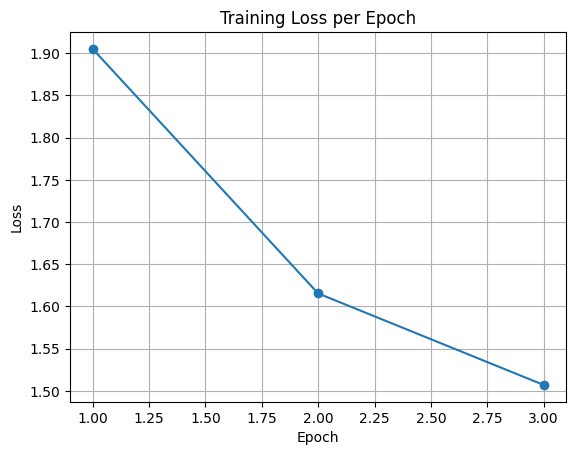

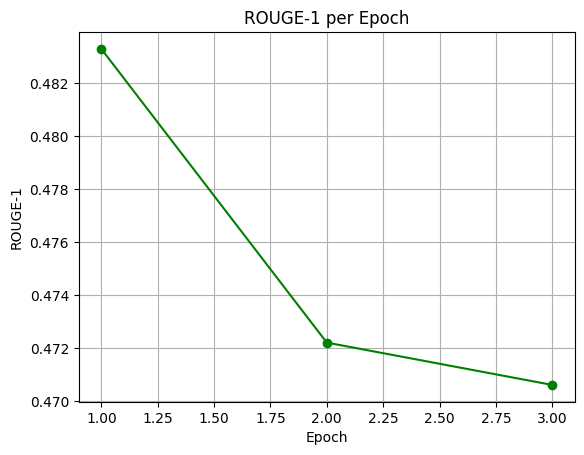

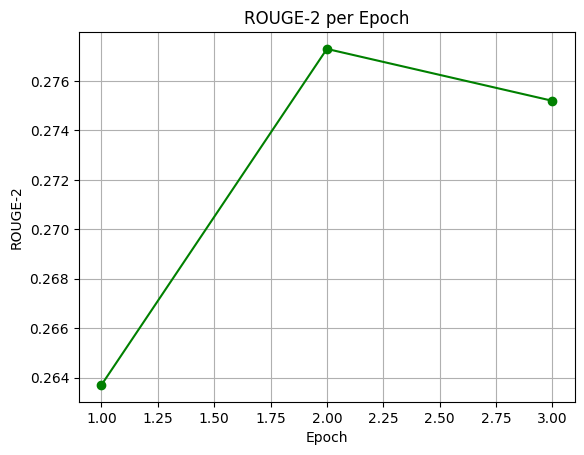

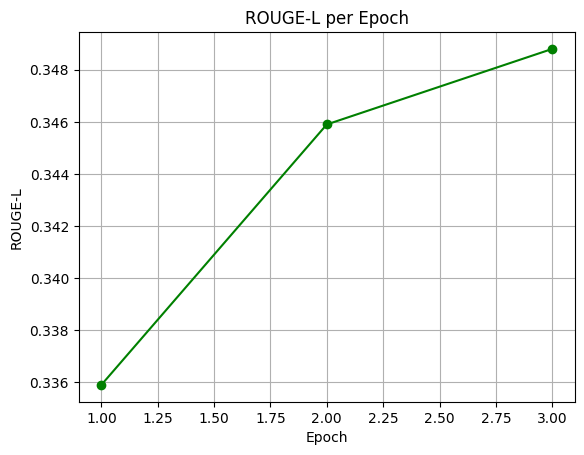

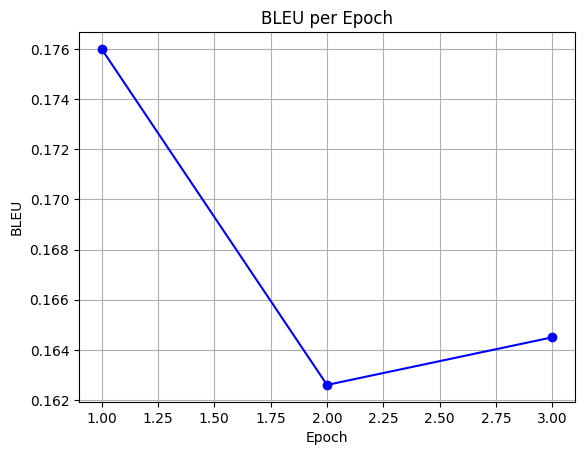

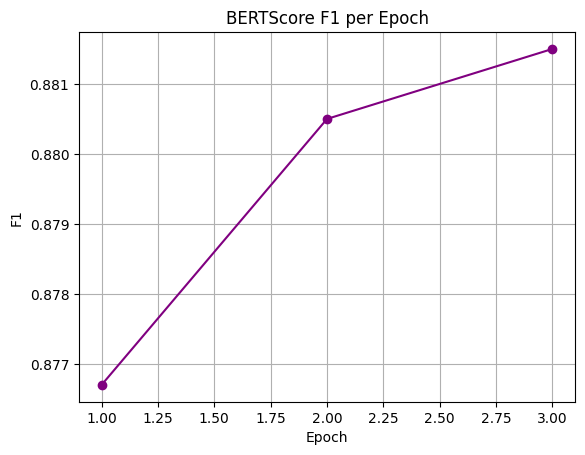

In [26]:
epochs = list(range(1, num_epochs + 1))

plt.figure()
plt.plot(epochs, losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, rouge1_scores, marker='o', color='green')
plt.title("ROUGE-1 per Epoch")
plt.xlabel("Epoch")
plt.ylabel("ROUGE-1")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, rouge2_scores, marker='o', color='green')
plt.title("ROUGE-2 per Epoch")
plt.xlabel("Epoch")
plt.ylabel("ROUGE-2")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, rouge_scores, marker='o', color='green')
plt.title("ROUGE-L per Epoch")
plt.xlabel("Epoch")
plt.ylabel("ROUGE-L")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, bleu_scores, marker='o', color='blue')
plt.title("BLEU per Epoch")
plt.xlabel("Epoch")
plt.ylabel("BLEU")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, bert_f1_scores, marker='o', color='purple')
plt.title("BERTScore F1 per Epoch")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.grid(True)
plt.show()
